# 책 판매량 데이터

30일 간의 책 판매량에 대한 데이터(book_sales.csv)를 사용하여 간단한 시계열 데이터 예측 모델을 만들어봅니다


## 1. 데이터 불러오기
`Date`컬럼을 인덱스로 설정하고, `Hardcover` 컬럼만 불러옵니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util

df = pd.read_csv("book_sales.csv", index_col='Date', parse_dates=['Date'],).drop('Paperback', axis=1)
df.head(10)

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191
2000-04-06,168
2000-04-07,170
2000-04-08,145
2000-04-09,184


## 2. 데이터 전처리


**시계열 데이터의 선형 회귀**

- 선형회귀 알고리즘은 목적 변수(y)를 가장 잘 설명하는 수식을 찾아냄
- 각 속성(feature) 별로 가중치를 곱하고, 가중치의 곱을 더하여 예측값을 도출
- 예측값과 실제값의 차이가 최소가 되는 가중치를 찾아내는 것이 선형회귀 모형의 학습 방법임
- 선형 회귀의 수식
```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```
- 
시계열 데이터가 갖는 속성: 시간 간격(time-step), 이전 값(lag)

### 속성1- 시간 간격(Time-step)

- 시간 간격은 시간을 나타내는 인덱스로부터 얻을 수 있는 속성
- `Time` : 시간의 변화를 순차적으로 증가하는 정수값으로 추출하여 지정

```
target = weight * time + bias
```

In [2]:
df['Time'] = np.arange(len(df.index))
df.head(10)

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4
2000-04-06,168,5
2000-04-07,170,6
2000-04-08,145,7
2000-04-09,184,8


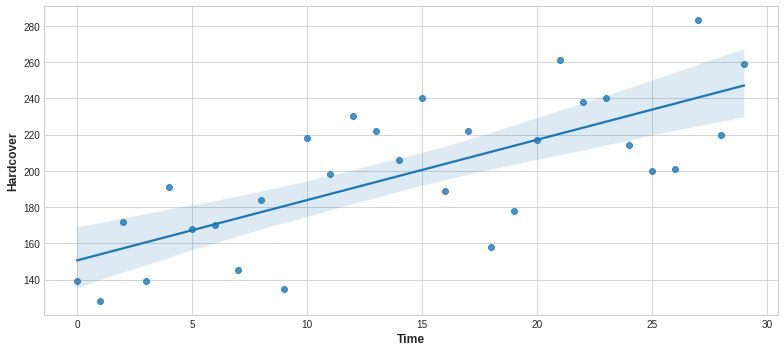

In [3]:
util.init_plt()
sns.regplot(x= df['Time'], y=df['Hardcover'])

In [4]:
# 데이터 분할

y = df["Hardcover"]  # the target
X = df.drop(['Hardcover'],axis=1,inplace=False)

## 3. 학습

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

## 4. 예측

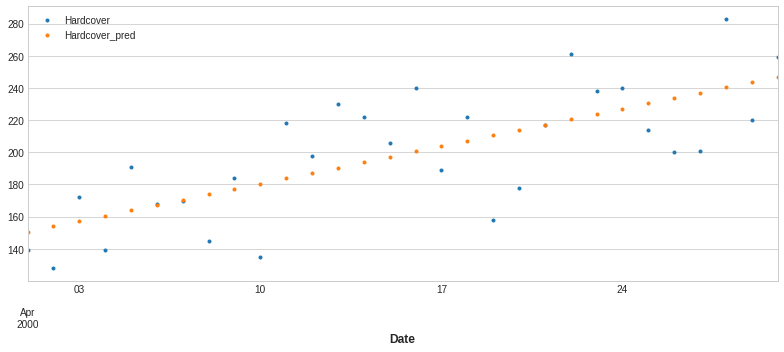

In [6]:
y_pred = model.predict(X)

df['Hardcover_pred'] = y_pred

ax = df.drop(['Time'], axis = 1).plot(style=".")

Hardcover 판매량은 시간이 지날 수록 증가하고 있다. 학습 모델을 사용하여 몇 달 후의 Hardcover 판매량도 예측할 수 있다.

----

## 2. 데이터 전처리
### 속성2 - 이전 값(Lag features)

한 시점의 이전 값(1-step lag)을 속성으로 사용하기 위해, `Hardcover` 컬럼의 값을 1만큼 값을 shift 시켜 `Lag_1` 컬럼을 신규로 생성

In [7]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head(10)

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0
2000-04-06,168,191.0
2000-04-07,170,168.0
2000-04-08,145,170.0
2000-04-09,184,145.0


`Lag_1`과 `Hardcover`의 상관관계를 확인

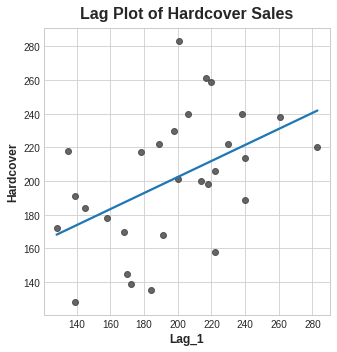

In [8]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

`Hardcover`와 `Lag_1`의 상관관계가 높으므로, `Lag_1`을 독립변수로 사용하여 선형 회귀 알고리즘을 만들었을 때 좋은 성능이 보여질 것으로 예상된다.

In [9]:
# 결측치 처리
df.dropna(inplace=True)

# 변수 할당
y = df["Hardcover"]  
X = df.drop(['Hardcover'],axis=1,inplace=False)

## 3. 학습


```
target = weight * lag + bias
```

In [10]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

## 4. 예측

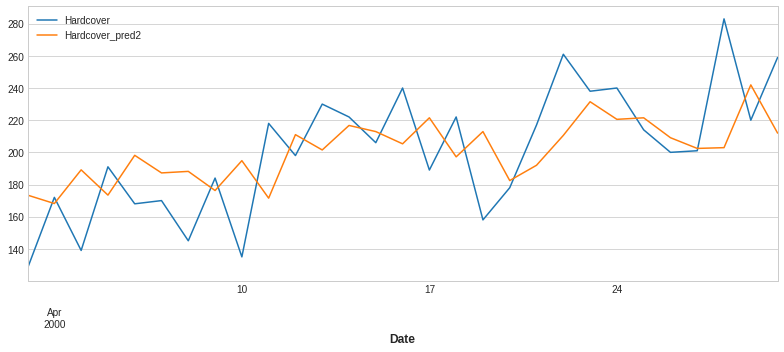

In [11]:
y_pred = model.predict(X)

df['Hardcover_pred2'] = y_pred

ax = df.drop(['Lag_1'], axis = 1).plot()

---
# 터널 교통량 데이터

*Tunnel Traffic* 는 2003년 11월부터 2005년 11월까지 스위스의 Baregg 터널을 통과하는 차량의 수에 대한 데이터입니다.

## 1. 데이터 불러오기

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# `parse_dates` : 지정한 컬럼이 날짜 타입으로 지정
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"], index_col='Day')

# 시간(DatetimeIndex)을 시계열(PeriodIndex) 형태로 변환
tunnel = tunnel.to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


## 2. 학습 모델(시간 간격 속성)

### 2-1 데이터 전처리

In [13]:
df = tunnel.copy()
df['Time'] = np.arange(len(tunnel.index))
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [14]:
# 변수 지정
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

### 2-2 선형회귀 알고리즘

In [15]:
from sklearn.linear_model import LinearRegression

# 학습
model = LinearRegression()
model.fit(X, y)
print('model: y = {:.2f} * Time + {:.2f}'.format(model.coef_[0], model.intercept_) )

model: y = 22.50 * Time + 98176.21


### 2-3 예측 결과 확인

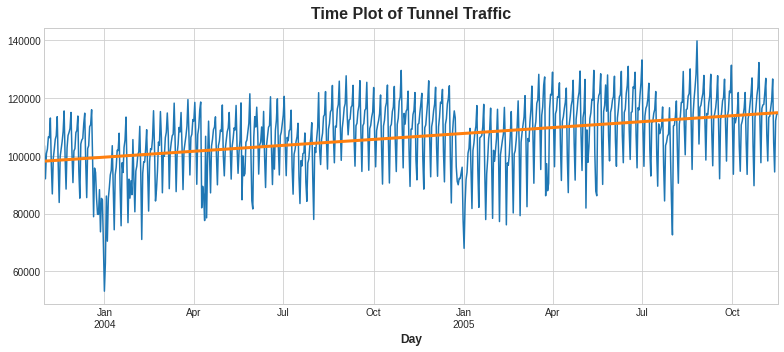

In [16]:
# 예측
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## 3. 학습 모델(이전 값)
### 3-1 데이터 전처리

 `shift`메서드를 사용하여 지연 속성 생성

In [17]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [18]:
# 결측치 처리
df.dropna(inplace=True)

# 변수 할당
y = df.loc[:, 'NumVehicles']
X = df.loc[:, ['Lag_1']]

### 3-2 선형회귀 알고리즘

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)


print('model: y = {:.2f} * Lag_1 + {:.2f}'.format(model.coef_[0], model.intercept_) )

model: y = 0.53 * Lag_1 + 49780.62


### 3-3 예측 결과 확인

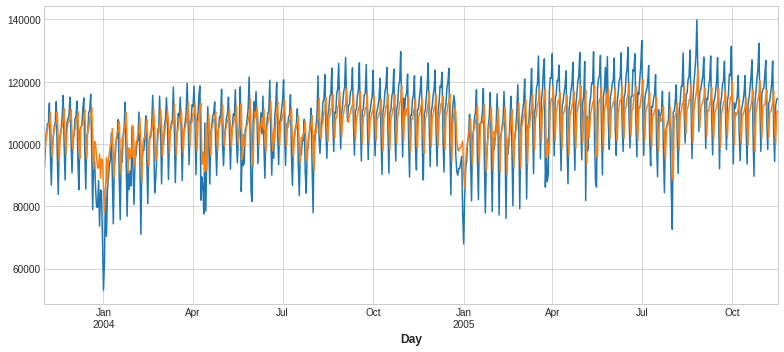

In [21]:
# 예측
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot()
ax = y_pred.plot()